In [1]:
import torch

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.CIFAR100(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
    target_transform=None
    )


test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
from torch.utils.data import DataLoader

In [4]:
BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True) 

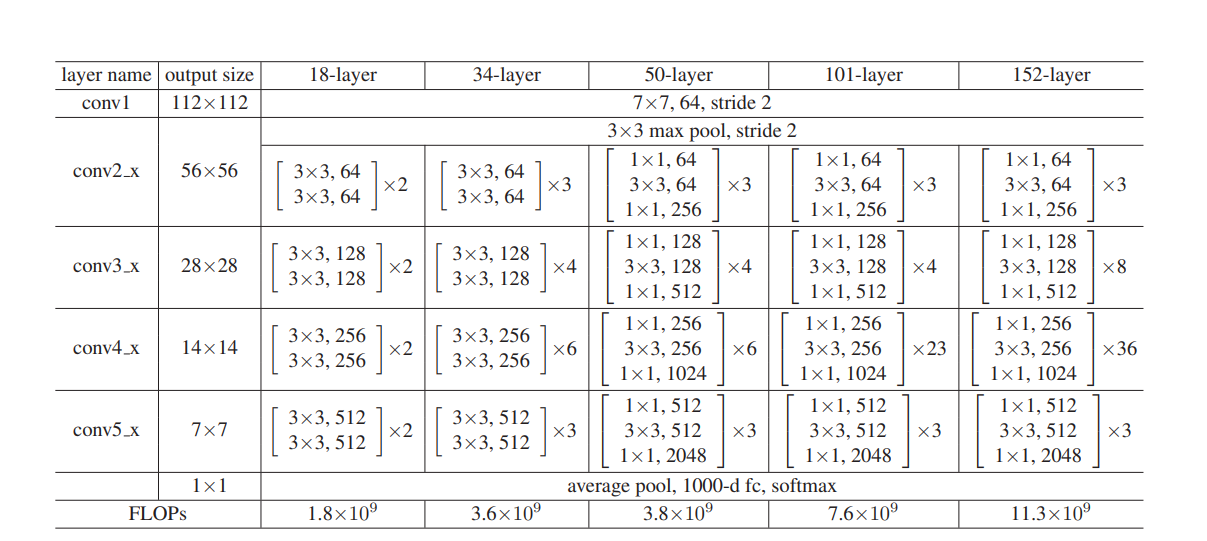

In [8]:
from torch import nn

class block(nn.Module):
    def __init__(self,input,output,id_downsamples=None,stride=1):
        super(block,self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels=input,out_channels=output,kernel_size=1,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(in_channels=output,out_channels=output,kernel_size=3,stride=stride,padding=1)
        self.bn2 = nn.BatchNorm2d(output)
        self.conv3 = nn.Conv2d(in_channels=output,out_channels=output*self.expansion,kernel_size=1,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(output*self.expansion)
        self.relu = nn.ReLU()
        self.id = id_downsamples

    

    def forward(self,x):
        identity = x

        x = self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)

        x = self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)

        x = self.conv3(x)
        x=self.bn3(x)

        if self.id is not None:
            identity = self.id(identity)

        x += identity

        x = self.relu(x)

        return x      


In [ ]:
class RessNet(nn.Module):
    def __init__(self, block , layers , image_channels , num_classes):
        super(RessNet,self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=image_channels,out_channels=64,kernel_size=7,stride=2,padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)


    def _make_layer(self,block,num_residual_bolck , output ,stride):
        id_downsamples = None
        layers = []

        

        
        

        

In [9]:
from torchvision import models

In [10]:
class ResNetV2(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNetV2, self).__init__()
        self.model = models.resnet50()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        x =self.model(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
torch.cuda.manual_seed(42)
model_0 = ResNetV2().to(device)

In [14]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.001)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 20

for epoch in tqdm(range(epochs)):

    train_loss , train_acc = 0,0

    model_0.train()

    for batch , (X,Y) in enumerate(train_dataloader):

        X,Y=X.to(device),Y.to(device)

        y_pred = model_0(X)

        loss = loss_fn(y_pred,Y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=Y,
                                 y_pred=y_pred.argmax(dim=1))
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


    test_loss , test_acc = 0 , 0
    model_0.eval()

    with torch.inference_mode():
        for X_test ,Y_test in test_dataloader:

            X_test,Y_test=X.to(device),Y.to(device)

            

            # forward pass
            test_pred = model_0(X_test)

            # calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, Y_test)

            # Accuracy
            test_acc += accuracy_fn(Y_test,test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch

        test_acc /= len(test_dataloader)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")





  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.95209 | Train acc: 47.28%


  5%|▌         | 1/20 [00:56<17:58, 56.74s/it]

Test loss: 0.34495 | Test acc: 93.75%

Train loss: 1.76993 | Train acc: 51.51%


 10%|█         | 2/20 [01:52<16:49, 56.10s/it]

Test loss: 1.62305 | Test acc: 93.75%

Train loss: 1.52596 | Train acc: 56.96%


 15%|█▌        | 3/20 [02:49<15:59, 56.46s/it]

Test loss: 0.19268 | Test acc: 93.75%

Train loss: 1.38275 | Train acc: 60.46%


 20%|██        | 4/20 [03:46<15:05, 56.56s/it]

Test loss: 0.03232 | Test acc: 100.00%

Train loss: 1.16148 | Train acc: 66.52%


 25%|██▌       | 5/20 [04:41<14:00, 56.05s/it]

Test loss: 0.03775 | Test acc: 100.00%

Train loss: 0.99500 | Train acc: 70.57%


 30%|███       | 6/20 [05:31<12:37, 54.10s/it]

Test loss: 0.00958 | Test acc: 100.00%

Train loss: 1.08926 | Train acc: 68.29%


 35%|███▌      | 7/20 [06:26<11:45, 54.26s/it]

Test loss: 0.05075 | Test acc: 100.00%

Train loss: 0.80805 | Train acc: 75.92%


 40%|████      | 8/20 [07:22<11:01, 55.09s/it]

Test loss: 0.17056 | Test acc: 93.75%

Train loss: 0.65969 | Train acc: 80.28%


 45%|████▌     | 9/20 [08:19<10:11, 55.57s/it]

Test loss: 0.00752 | Test acc: 100.00%

Train loss: 0.53860 | Train acc: 83.89%


 50%|█████     | 10/20 [09:14<09:13, 55.37s/it]

Test loss: 0.01368 | Test acc: 100.00%

Train loss: 0.80400 | Train acc: 76.58%


 55%|█████▌    | 11/20 [10:12<08:26, 56.28s/it]

Test loss: 0.01247 | Test acc: 100.00%

Train loss: 0.71431 | Train acc: 78.78%


 60%|██████    | 12/20 [11:09<07:32, 56.52s/it]

Test loss: 0.02749 | Test acc: 100.00%

Train loss: 0.86589 | Train acc: 74.69%


 65%|██████▌   | 13/20 [12:05<06:33, 56.20s/it]

Test loss: 0.00624 | Test acc: 100.00%

Train loss: 0.64085 | Train acc: 80.69%


 70%|███████   | 14/20 [13:03<05:41, 56.92s/it]

Test loss: 0.03079 | Test acc: 100.00%

Train loss: 0.49384 | Train acc: 85.14%


 75%|███████▌  | 15/20 [13:59<04:43, 56.64s/it]

Test loss: 0.27811 | Test acc: 93.75%

Train loss: 0.41105 | Train acc: 87.51%


 80%|████████  | 16/20 [14:55<03:45, 56.47s/it]

Test loss: 0.02780 | Test acc: 100.00%

Train loss: 0.51027 | Train acc: 84.71%


 85%|████████▌ | 17/20 [15:53<02:50, 56.82s/it]

Test loss: 0.00294 | Test acc: 100.00%

Train loss: 0.43461 | Train acc: 86.85%


 90%|█████████ | 18/20 [16:50<01:53, 56.78s/it]

Test loss: 0.12555 | Test acc: 93.75%

Train loss: 0.30161 | Train acc: 91.00%


 95%|█████████▌| 19/20 [17:40<00:54, 54.77s/it]

Test loss: 0.06724 | Test acc: 100.00%

Train loss: 0.59683 | Train acc: 82.74%


100%|██████████| 20/20 [18:36<00:00, 55.83s/it]

Test loss: 0.00172 | Test acc: 100.00%



In [38]:
def eval_model_gpu(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss,acc = 0,0
    
    model.eval()
    with torch.inference_mode():
        for X,Y in tqdm(data_loader):
            # Make prediction
            X,Y = X.to(device),Y.to(device)
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,Y)

            acc += accuracy_fn(Y,y_pred.argmax(dim=1))
            
        
        # Scale loss and acc to find the average loss/acc per batch

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"Model_name": model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}




In [39]:
model_result = eval_model_gpu(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

100%|██████████| 313/313 [00:06<00:00, 46.91it/s]


In [40]:
model_result

{'Model_name': 'ResNetV2',
 'model_loss': 4.299639701843262,
 'model_acc': 35.77276357827476}

In [ ]:
# -*- coding: utf-8 -*-
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
*    2022-12-20 Update comments, code revision, checked still works with latest PyTorch version
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)




In [ ]:
def ResNet50(img_channel=3, num_classes=100):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet101(img_channel=3, num_classes=1000).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 1000])
    print(y.size())


if __name__ == "__main__":
    test()

In [ ]:
model_2 = ResNet50(img_channel=3,num_classes=100).to(device)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10

for epoch in tqdm(range(epochs)):

    train_loss , train_acc = 0,0

    model_2.train()

    for batch , (X,Y) in enumerate(train_dataloader):

        X,Y=X.to(device),Y.to(device)

        y_pred = model_2(X)

        loss = loss_fn(y_pred,Y)

        train_loss += loss
        train_acc += accuracy_fn(y_true=Y,
                                 y_pred=y_pred.argmax(dim=1))
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


    test_loss , test_acc = 0 , 0
    model_2.eval()

    with torch.inference_mode():
        for X_test ,Y_test in test_dataloader:

            X_test,Y_test=X.to(device),Y.to(device)

            

            # forward pass
            test_pred = model_2(X_test)

            # calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, Y_test)

            # Accuracy
            test_acc += accuracy_fn(Y_test,test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch

        test_acc /= len(test_dataloader)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")





In [ ]:
def eval_model_gpu(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss,acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,Y in tqdm(data_loader):
            # Make prediction
            X,Y = X.to(device),Y.to(device)
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,Y)

            acc += accuracy_fn(Y,y_pred.argmax(dim=1))
            
        
        # Scale loss and acc to find the average loss/acc per batch

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"Model_name": model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}




In [ ]:
model_result = eval_model_gpu(model=model_2,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

In [ ]:
model_result